In [24]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

me=0.511
e=0.303
p_=5
Z=29
epsilon=np.sqrt(p_**2+me**2)
h_=np.log((epsilon+p_)/(epsilon-p_))

@jit(nopython=True,cache=True)
def H_cap(epsilon_f,p_f):
    res=np.log((epsilon*epsilon_f+p_*p_f-me**2)/(epsilon*epsilon_f-p_*p_f-me**2))
    return res

@jit(nopython=True,cache=True)
def h_1(epsilon_f,p_f):
    res=np.log((epsilon_f+p_f)/(epsilon_f-p_f))
    return res

@jit(nopython=True,cache=True)
def sigma_omega(omega):
    epsilon_f=epsilon-omega
    p_f=np.sqrt(epsilon_f**2-me**2)
    h_1_=h_1(epsilon_f,p_f)
    res=Z**2*e**6/(8*(2*np.pi)**3*me**2*omega*p_)*p_f*(4/3-epsilon*epsilon_f*(p_**2+p_f**2)/(p_**2*p_f**2)+me**2*(h_*epsilon_f/p_**3+h_1_*epsilon/p_f**3-h_*h_1_/p_/p_f)\
        +H_cap(epsilon_f,p_f)*(8*epsilon*epsilon_f/3/p_/p_f+omega**2/p_**3/p_f**3*(epsilon**2*epsilon_f*2+p_**2*p_f**2+me**2*epsilon*epsilon_f)\
                               +me**2*omega/2/p_/p_f*(h_*(epsilon*epsilon_f+p_**2)/p_**3-h_1_*(epsilon*epsilon_f+p_f**2)/p_f**3)))
    # 当p_f趋0时上式子发散
    return res
print(sigma_omega(epsilon - me))

85297.85271934012


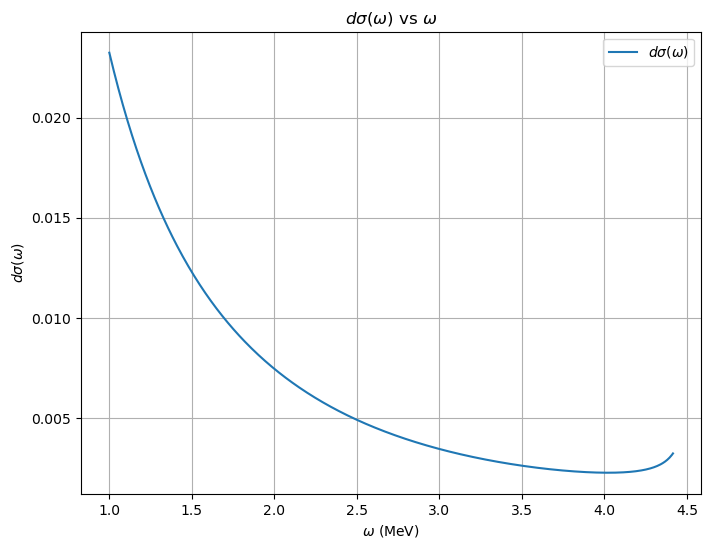

In [25]:
# Define the range of omega
omega_values = np.linspace(1, epsilon - me-0.1, 500)  # Avoid omega = 0 and ensure epsilon_f > me
sigma_values = [sigma_omega(omega) for omega in omega_values]

# Plot the results
fig = plt.figure(figsize=(8, 6))
plt.plot(omega_values, sigma_values, label=r'$d\sigma(\omega)$')
plt.xlabel(r'$\omega$ (MeV)')
plt.ylabel(r'$d\sigma(\omega)$')
plt.title(r'$d\sigma(\omega)$ vs $\omega$')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# 能谱图
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import vegas
from mpi4py import MPI
import time  # 导入 time 模块
import sys

# 获取当前时间，生成带时间戳的文件名
current_time = time.strftime("%m%d_%H%M%S")
output_file = f"rps_{current_time}.txt" 
filename = f"rps_{current_time}.npz"

# 在主程序开始时记录时间
start_time = time.time()

me=0.511
e=0.303
p_=5
Z=29
epsilon=np.sqrt(p_**2+me**2)
@jit(nopython=True)
def four_vec(energy,m,theta,phi):
    p=np.sqrt(energy**2-m**2)
    res=np.array([energy,p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi),p*np.cos(theta)])
    return res
@jit(nopython=True)
def three_vec(energy,m,theta,phi):
    p=np.sqrt(energy**2-m**2)
    res=np.array([p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi),p*np.cos(theta)])
    return res

@jit(nopython=True)
def kappa1(omega,theta_k,phi_k,epsilon_f,theta_f,phi_f):
    res= epsilon_f-three_vec(omega,0,theta_k,phi_k)@three_vec(epsilon_f,me,theta_f,phi_f)/omega
    return res

@jit(nopython=True)
def sigma_pre(omega,theta_k,phi_k,theta_f,phi_f):
    epsilon_f=epsilon-omega
    p_f=np.sqrt(epsilon_f**2-me**2)
    kappa1_val=kappa1(omega,theta_k,phi_k,epsilon_f,theta_f,phi_f)
    kappa=epsilon-np.cos(theta_k)*p_
    q_vec=three_vec(epsilon_f,me,theta_f,phi_f)-np.array([0,0,p_])+three_vec(omega,0 ,theta_k,phi_k)
    q_sq=q_vec@q_vec
    res=Z**2*e**6/(8*(2*np.pi)**5*omega*p_*q_sq**2)*(p_f*me**2)*np.sin(theta_f)*np.sin(theta_k)\
        *(q_sq/kappa/kappa1_val/me**2*(2*epsilon**2+2*epsilon_f**2-q_sq)\
          +q_sq*(1/kappa-1/kappa1_val)**2-4*(epsilon/kappa1_val-epsilon_f/kappa)**2\
            +2*omega*q_sq/me**2*(1/kappa1_val-1/kappa)-2*omega**2/me**2*(kappa1_val/kappa+kappa/kappa1_val))
    return res



# 定义积分域
theta_f_min, theta_f_max = 0, np.pi
phi_f_min, phi_f_max = 0, 2 * np.pi
theta_k_min, theta_k_max = 0, np.pi
phi_k_min, phi_k_max = 0, 2 * np.pi

def integrand(x,omega):
    theta_f, phi_f, theta_k, phi_k = x  # 解包变量
    return sigma_pre(omega,theta_k,phi_k,theta_f,phi_f)

results=[]
nitn0=6
neval0=8000
nitn1=10
neval1=11000
dot_val=80
omega_values = np.linspace(1,epsilon- me-0.1, dot_val)


# 使用 MPI 进行并行计算
comm = MPI.COMM_WORLD
rank = comm.Get_rank()  # 获取当前进程的rank
size = comm.Get_size()  # 获取总进程数

for omega_for in omega_values:
    # 定义 vegas 积分器
    integ = vegas.Integrator([
        [theta_f_min, theta_f_max],       # theta_f
        [phi_f_min, phi_f_max],           # phi_f
        [theta_k_min, theta_k_max],       # theta_k
        [phi_k_min, phi_k_max]            # phi_k
        ],mpi=True)

    integ(lambda x: integrand(x, omega_for), nitn=nitn0, neval=neval0)

    result = integ(lambda x: integrand(x, omega_for), nitn=nitn1, neval=neval1)

    if rank == 0:
        res=result.mean   # 乘上最后一个系数
        results.append(res)    
 

# 主进程保存结果
if rank == 0:
    np.savez(filename, omega_values=omega_values, results=results)


# 计算结束时间并输出
end_time = time.time()
# 计算总耗时
elapsed_time = end_time - start_time


if rank == 0:
    # 仅主进程将输出重定向到文件
    sys.stdout = open(output_file, "w", encoding="utf-8")
    print(f"总运行时间: {elapsed_time:.2f} 秒\n")
    print("基本参数:")
    print("Z=",Z,"p=",p_)
    print("\n积分参数：")
    print("训练参数 nitn=",nitn0,"neval=",neval0,"\n结果参数 nitn=",nitn1,"neval=",neval1)
    print("\n计算的点数：",dot_val)
    # 关闭文件（仅主进程）




In [ ]:
# 角度分布图
# -*- coding: utf-8 -*-

import numpy as np
import math
from numba import jit
import vegas
from mpi4py import MPI
import time  # 导入 time 模块
import sys


# 获取当前时间，生成带时间戳的文件名
current_time = time.strftime("%m%d_%H%M%S")
output_file = f"rtk_{current_time}.txt" 
filename = f"rtk_{current_time}.npz"

# 在主程序开始时记录时间
start_time = time.time()
me=0.511
e=0.303
p_=5
Z=29
epsilon=np.sqrt(p_**2+me**2)
@jit(nopython=True)
def four_vec(energy,m,theta,phi):
    p=np.sqrt(energy**2-m**2)
    res=np.array([energy,p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi),p*np.cos(theta)])
    return res
@jit(nopython=True)
def three_vec(energy,m,theta,phi):
    p=np.sqrt(energy**2-m**2)
    res=np.array([p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi),p*np.cos(theta)])
    return res

@jit(nopython=True)
def kappa1(omega,theta_k,phi_k,epsilon_f,theta_f,phi_f):
    res= epsilon_f-three_vec(omega,0,theta_k,phi_k)@three_vec(epsilon_f,me,theta_f,phi_f)/omega
    return res

@jit(nopython=True)
def sigma_pre(omega,theta_k,phi_k,theta_f,phi_f):
    epsilon_f=epsilon-omega
    p_f=np.sqrt(epsilon_f**2-me**2)
    kappa1_val=kappa1(omega,theta_k,phi_k,epsilon_f,theta_f,phi_f)
    kappa=epsilon-np.cos(theta_k)*p_
    q_vec=three_vec(epsilon_f,me,theta_f,phi_f)-np.array([0,0,p_])+three_vec(omega,0 ,theta_k,phi_k)
    q_sq=q_vec@q_vec
    res=Z**2*e**6/(8*(2*np.pi)**5*omega*p_*q_sq**2)*(p_f*me**2)*np.sin(theta_f)\
        *(q_sq/kappa/kappa1_val/me**2*(2*epsilon**2+2*epsilon_f**2-q_sq)\
          +q_sq*(1/kappa-1/kappa1_val)**2-4*(epsilon/kappa1_val-epsilon_f/kappa)**2\
            +2*omega*q_sq/me**2*(1/kappa1_val-1/kappa)-2*omega**2/me**2*(kappa1_val/kappa+kappa/kappa1_val))
    return res


# 定义积分域
omega0=3.5
theta_f_min, theta_f_max = 0, np.pi
phi_f_min, phi_f_max = 0, 2 * np.pi
theta_k_min, theta_k_max = 0, np.pi
phi_k_min, phi_k_max = 0, 2 * np.pi

def integrand(x,theta_k):
    theta_f, phi_f, phi_k = x  # 解包变量
    return sigma_pre(omega0,theta_k,phi_k,theta_f,phi_f)


results=[]
nitn0=6
neval0=5000
nitn1=10
neval1=8000
dot_val=100
# 生成两个区间的点
theta_k_vals_0 = np.linspace(0, 0.5, int(dot_val*0.8))
theta_k_vals_1 = np.linspace(0.5, np.pi, int(dot_val*0.2) + 1)[1:]  # 去除重复的 0.5 点
# 拼接两个区间的点
theta_k_vals = np.concatenate((theta_k_vals_0, theta_k_vals_1))


# 使用 MPI 进行并行计算
comm = MPI.COMM_WORLD
rank = comm.Get_rank()  # 获取当前进程的rank
size = comm.Get_size()  # 获取总进程数

for theta_k_for in theta_k_vals:
    # 定义 vegas 积分器
    integ = vegas.Integrator([
        [theta_f_min, theta_f_max],       # theta_f
        [phi_f_min, phi_f_max],           # phi_f
        [phi_k_min, phi_k_max]            # phi_k
        ],mpi=True)

    integ(lambda x: integrand(x, theta_k_for), nitn=nitn0, neval=neval0)

    result = integ(lambda x: integrand(x, theta_k_for), nitn=nitn1, neval=neval1)

    if rank == 0:
        res=result.mean
        results.append(res)    
 

# 主进程保存结果
if rank == 0:
    np.savez(filename, theta_k_vals=theta_k_vals, results=results)


# 计算结束时间并输出
end_time = time.time()
# 计算总耗时
elapsed_time = end_time - start_time


if rank == 0:
    # 仅主进程将输出重定向到文件
    sys.stdout = open(output_file, "w", encoding="utf-8")
    print(f"总运行时间: {elapsed_time:.2f} 秒\n")
    print("基本参数:")
    print("Z=",Z,"l=",l,"p=",p_,"omega0=",omega0)
    print("\n积分参数：")
    print("训练参数 nitn=",nitn0,"neval=",neval0,"\n结果参数 nitn=",nitn1,"neval=",neval1)
    print("\n计算的点数：",dot_val)
    # 关闭文件（仅主进程）
    sys.stdout.close()  # 这样可以确保所有内容被写入文件





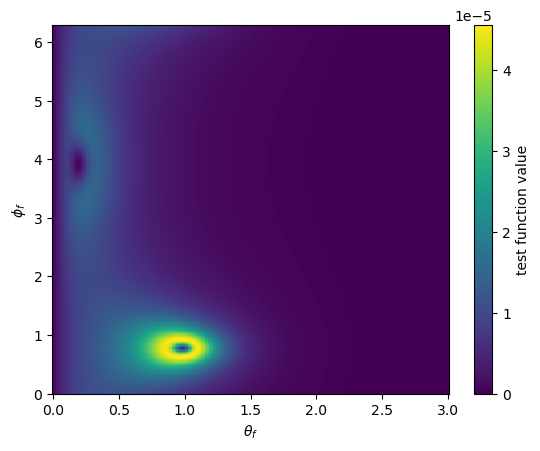

In [41]:
def test(theta_f,phi_f):
    return sigma_pre(1,1,np.pi/4,theta_f,phi_f)

# 生成 theta_f 和 phi_f 的数据
theta_f_vals = np.linspace(0, 3, 300)  # 从 0 到 pi
phi_f_vals = np.linspace(0, 2*np.pi, 300)  # 从 0 到 2*pi
theta_f, phi_f = np.meshgrid(theta_f_vals, phi_f_vals)

# 计算 test 函数值
z = np.frompyfunc(test, 2, 1)(theta_f, phi_f).astype(np.float64)  # 关键部分

# 创建图形
fig, ax = plt.subplots()

# 绘制 pcolor 图
c = ax.pcolor(theta_f, phi_f, z)

# 添加 colorbar
plt.colorbar(c, label='test function value')

# 设置 x 和 y 轴的标签
ax.set_xlabel(r'$\theta_f$')
ax.set_ylabel(r'$\phi_f$')

# 显示图形
plt.show()

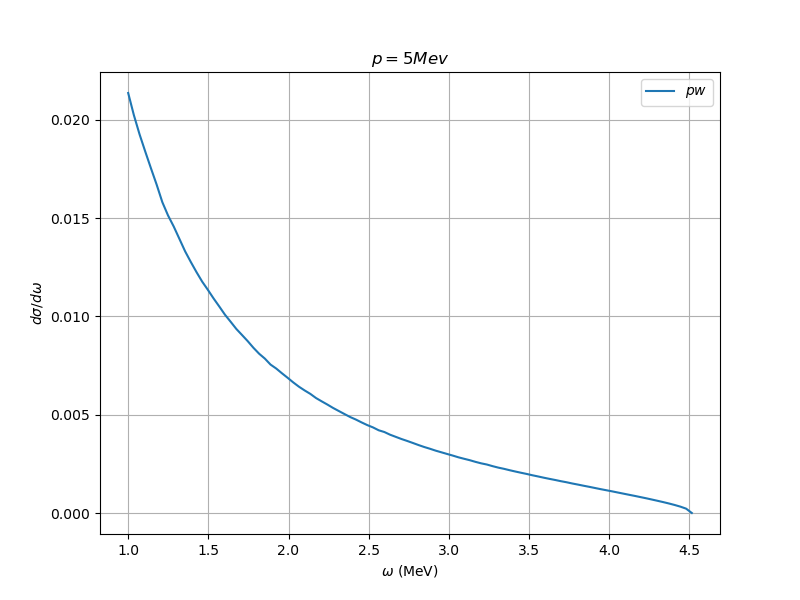

In [3]:
# 关于omega 的能谱图
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
 
data = np.load('rps_0305_161023.npz')
omega_values = data['omega_values']
P_values = data['results']
# 创建图形
fig = plt.figure(figsize=(8, 6))
# 3. 绘制图表
plt.plot(omega_values, P_values, label=r'$pw$')
plt.xlabel(r'$\omega$ (MeV)')
plt.ylabel(r'$d\sigma/d\omega$')
plt.title(r'$p=5 Mev$')
plt.legend()
plt.grid(True)
plt.show()


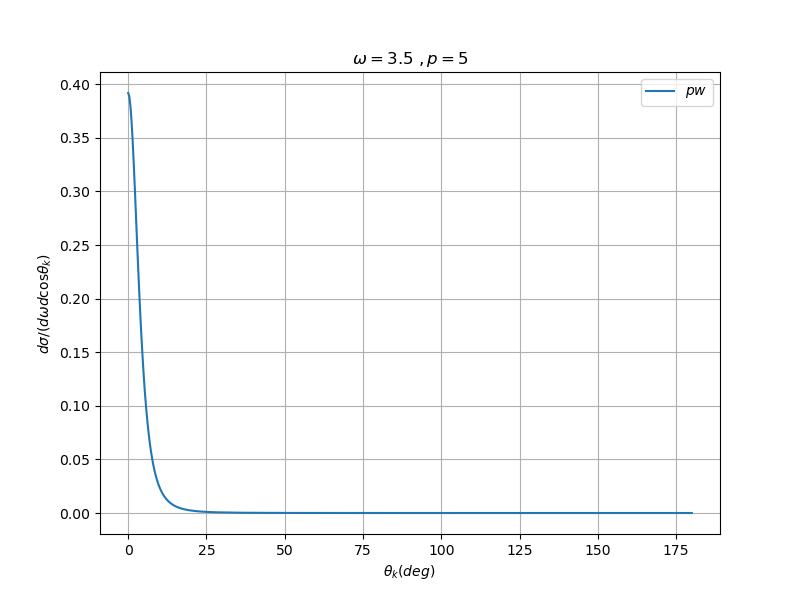

In [6]:
# 关于theta_k的能谱图
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

# 1. 读取 .npz 文件

data = np.load('rptk_0305_163239.npz')
theta_k_vals = data['theta_k_vals']
P_vals = data['results']
# 创建图形
fig = plt.figure(figsize=(8, 6))
# 3. 绘制图表
plt.plot(theta_k_vals/np.pi*180, P_vals, label=r'$pw$')
plt.xlabel(r'$\theta_k(deg)$ ')
plt.ylabel(r'$d\sigma /(d\omega d\text{cos}\theta_k)$')
plt.title(r'$\omega=3.5\ ,p=5$')
plt.legend()
plt.grid(True)
plt.show()